<h1>Capstone 1: Inferential Statistics</h1>

<a id='TOC'></a>
<strong>Table of Contents</strong>
<ol>
    <li>Preliminaries</li>
    <ol>
        <li><a href=#Sec01A>Import EMS Incident Data</a></li>
        <li><a href=#Sec01B>Preprocess Dataset</a></li>
        <li><a href=#Sec01C>Segment Variables</a></li>
    </ol>
    <li>Preliminary Statistics</li>
    <ol>
        <li><a href=#Sec02A>Correlations between Numerical Variables</a></li>
        <li><a href=#Sec02B>Association between Categorical Variables</a></li>
    </ol>
    <li>Response Times</li>
    <ol>
        <li><a href=#Sec03A>Preliminary Data Inspection &amp; Summary Statistics</a></li>
        <li><a href=#Sec03B>Sample Statistics by Outcome Group</a></li> 
        <li><a href=#Sec03C>Frequentist Test (Two-Sample)</a></li>
    </ol>
</ol>

<p>The goal of this project is to develop machine learning models that predict whether or not the outcome of an EMS incident will result in a fatality. This is a supervised, binary classification problem. Analyses will be performed on a collection of nearly 8 million records of documented incidents, which span the six year period from January 2013 through December 2018, and appropriate predictive models will be developed to achieve the primary objective. This dataset is robust and contains several feature variables, of mixed data types, that describe both various attributes of each incident as well as the responsive action taken by the FDNY. All of the aforementioned factors affect an individual’s survivability once a response is initiated.</p>

Various inferential statistics techniques will be performed on the dataset prior to the development of any ML algorithms. One purpose of this process is to examine the relationships between all variables within the dataset in greater depth than <a href="https://github.com/jdwill917/SB-DSCT-Repo/blob/master/Capstones/Capstone%201/code/CP1-02_EDA.ipynb" target="_blank">preliminary EDA permits</a>. In addition, any feature variable that has a significant impact on the target variable (`fatality`) will also be revealed through these measures.

<h2 style="text-transform: uppercase;">1. Preliminaries</h2>

<a id='Sec01A'></a>
<h4>1A: Import EMS Incident Data</h4>

In [1]:
# Import packages and modules
import pandas as pd
import numpy as np

from scipy import stats
from statsmodels.stats.weightstats import ztest, ttest_ind

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
sb.set(style='whitegrid', palette='pastel', color_codes=True)
sb.mpl.rc('figure', figsize=(15,10))

In [2]:
# Assign file path
input_path = '../data/clean_EMS_data.csv'

# Read CSV data into a Pandas DataFrame
datetime_cols = ['incident_datetime',
                 'first_assignment_datetime',
                 'first_activation_datetime',
                 'first_on_scene_datetime',
                 'first_to_hosp_datetime',
                 'first_hosp_arrival_datetime',
                 'incident_close_datetime']

df = pd.read_csv(input_path,compression='gzip',
                 parse_dates=datetime_cols,
                 index_col=['incident_datetime'])

In [3]:
df.info(verbose=True,memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8054500 entries, 2018-12-31 23:59:46 to 2013-01-09 09:05:12
Data columns (total 29 columns):
year                           int64
month                          int64
day                            int64
hour                           int64
weekday                        int64
borough                        object
zipcode                        float64
latitude                       float64
longitude                      float64
aland_sqmi                     float64
awater_sqmi                    float64
initial_call_type              object
initial_severity_level         int64
final_call_type                object
final_severity_level           int64
held_indicator                 object
first_assignment_datetime      datetime64[ns]
incident_dispatch_area         object
dispatch_time                  int64
first_activation_datetime      datetime64[ns]
first_on_scene_datetime        datetime64[ns]
travel_time                    int6

<p><a href=#TOC>TOC</a></p>

<a id="Sec01B"></a>
<h4>1B: Preprocess Dataset</h4>

In [4]:
# Change dtypes
df['weekday'] = df.weekday.astype('category')
df['borough'] = df.borough.astype('category')
df['zipcode'] = df.zipcode.astype('category')
df['incident_disposition_code'] = df.incident_disposition_code.astype('category')

In [5]:
# Remove immaterial columns
list_of_cols = ['latitude','longitude',
                'aland_sqmi','awater_sqmi','held_indicator',
                'first_assignment_datetime','incident_dispatch_area',
                'first_activation_datetime','first_on_scene_datetime',
                'first_to_hosp_datetime','first_hosp_arrival_datetime',
                'incident_close_datetime']
df.drop(list_of_cols,axis=1,inplace=True)

In [6]:
df.info(verbose=True,memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8054500 entries, 2018-12-31 23:59:46 to 2013-01-09 09:05:12
Data columns (total 17 columns):
year                         int64
month                        int64
day                          int64
hour                         int64
weekday                      category
borough                      category
zipcode                      category
initial_call_type            object
initial_severity_level       int64
final_call_type              object
final_severity_level         int64
dispatch_time                int64
travel_time                  int64
response_time                int64
incident_disposition_code    category
life_threatening             bool
fatality                     bool
dtypes: bool(2), category(4), int64(9), object(2)
memory usage: 1.6 GB


In [7]:
df.head()

,year,month,day,hour,weekday,borough,zipcode,initial_call_type,initial_severity_level,final_call_type,final_severity_level,dispatch_time,travel_time,response_time,incident_disposition_code,life_threatening,fatality
incident_datetime,,,,,,,,,,,,,,,,,
2018-12-31 23:59:46,2018,12,31,23,1,BROOKLYN,11201.0,CARDBR,2,CARDBR,2,8,453,461,82,True,False
2018-12-31 23:49:42,2018,12,31,23,1,BROOKLYN,11201.0,UNC,2,UNC,2,25,303,328,82,True,False
2018-12-31 23:24:58,2018,12,31,23,1,BROOKLYN,11201.0,SICK,6,SICK,6,11,414,425,82,False,False
2018-12-31 23:04:54,2018,12,31,23,1,BROOKLYN,11201.0,SICK,6,SICK,6,11,668,679,93,False,False
2018-12-31 22:08:50,2018,12,31,22,1,BROOKLYN,11201.0,SEIZR,3,SEIZR,3,12,443,455,82,True,False


<a href=#TOC>TOC</a>

<a id="Sec01C"></a>
<h4>1C: Segment  Variables</h4>

In [8]:
# Numeric feature variables
num_var = ['year','month','day','hour','dispatch_time','travel_time','response_time']
X1 = df[num_var]

# Categorical feature variables
cat_var = ['weekday','borough','zipcode','final_call_type','final_severity_level','life_threatening']
X2 = df[cat_var]

# Target variable
Y = df[['fatality']]

In [9]:
x1 = X1.values
x2 = X2.values
y = Y.values
print("x1: ", type(x1), x1.shape)
print("x2: ", type(x2), x2.shape)
print("y:  ", type(y), y.shape)

x1:  <class 'numpy.ndarray'> (8054500, 7)
x2:  <class 'numpy.ndarray'> (8054500, 6)
y:   <class 'numpy.ndarray'> (8054500, 1)


<p><a href=#TOC>TOC</a></p>

***

<h2 style="text-transform: uppercase;">2. Preliminary Statistics</h2>

<a id='Sec02A'></a>
<h4>2A: Correlations between Numerical Variables</h4>

<p>What is the correlation between pairs of similar <em>numerical</em> variables within the dataset?</p>

+ `initial_severity_level` and `final_severity_level`
+ `dispatch_time` and `response_time`
+ `travel_time` and `response_time`

In [10]:
# Correlation - Initial and Final Severity Levels
x1 = df.initial_severity_level.values
y1 = df.final_severity_level.values
rho1 = np.corrcoef(x1,y1)[0][1]

# Correlation - Dispatch and Response Times
x2 = df.dispatch_time.values
y2 = df.response_time.values
rho2 = np.corrcoef(x2,y2)[0][1]

# Correlation - Travel and Response Times
x3 = df.travel_time.values
y3 = df.response_time.values
rho3 = np.corrcoef(x3,y3)[0][1]

# Output correlation statistics
print('CORRELATION STATISTICS')
print()
print(f'Initial vs. Final Severity Level: \u03C1 = {rho1:.4f}')
print(f'Dispatch vs. Response Times:      \u03C1 = {rho2:.4f}')
print(f'Travel vs. Response Times:        \u03C1 = {rho3:.4f}')

CORRELATION STATISTICS

Initial vs. Final Severity Level: ρ = 0.9352
Dispatch vs. Response Times:      ρ = 0.7715
Travel vs. Response Times:        ρ = 0.7501


There is a strong correlation between the `initial_severity_level` and the `final_severity_level` ($\rho = 0.9352$). This indicates that the determination for the severity of an incident made by dispatch--based on the information obtained by a caller--closely aligns with the determination made by on-scene EMS crew. Similarly, there are moderately strong correlations between the `response_time` and both `dispatch_time` ($\rho = 0.7715$) and `travel_time` ($\rho = 0.7501$).

For these reasons, the `initial_severity_level`, `dispatch_time` and `travel_time` will all be omitted from any analyses used to develop ML algorithms given they are redundant predictor variable. <p><a href=#TOC>TOC</a></p>

<a id="Sec02B"></a>
<h4>2B: Association between Categorical Variables</h4>

<p>What is the association between pairs of similar <em>categorical</em> variables within the dataset?</p>

+ `initial_call_type` and `final_call_type`
+ `incident_disposition_code` and `fatality`

In [11]:
# Define Cramér's V
def cramers_v(confusion_matrix,corrected=False):
    """
    Calculate Cramer's V statistic for measure of association
    between two categorical features
    """
    # Calculate phi coefficient
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2 / n
    
    # Calculate Cramér's statistic
    r,k = confusion_matrix.shape
    cV = np.sqrt(phi2/(min(k-1,r-1)))
    
    # Calculate bias corrections
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    kcorr = k - ((k-1)**2)/(n-1)
    rcorr = r - ((r-1)**2)/(n-1)
    
    # Calculate corrected Cramér's statistic
    cVcorr = np.sqrt(phi2corr/(min(kcorr-1,rcorr-1)))
    
    if corrected==False:
        statistic = cV
    else:
        statistic = cVcorr
    
    return statistic

In [12]:
# Create confusion matrix for features
conf_mtrx1 = pd.crosstab(df.initial_call_type,df.final_call_type).values
conf_mtrx2 = pd.crosstab(df.incident_disposition_code,df.fatality).values

# Calculate Cramér's V statistics
cV_stat1, cV_stat2 = cramers_v(conf_mtrx1), cramers_v(conf_mtrx2)
cVcorr_stat1, cVcorr_stat2 = cramers_v(conf_mtrx1,True), cramers_v(conf_mtrx2,True)

# Output association statistics
print('ASSOCIATION STATISTICS (Cramér\'s V / Corr. V)')
print()
print(f'Initial vs. Final Call Type:   {cV_stat1:.4f} / {cVcorr_stat1:.4f}')
print(f'Disposition Code vs. Fatality: {cV_stat2:.4f} / {cVcorr_stat2:.4f}')

ASSOCIATION STATISTICS (Cramér's V / Corr. V)

Initial vs. Final Call Type:   0.7421 / 0.7421
Disposition Code vs. Fatality: 1.0000 / 1.0000


There is a moderately strong association between the `initial_call_type` and the `final_call_type`. This indicates that the determination for the incident call type made by dispatch--based on the information obtained by a caller--aligns closely to the determination made by on-scene EMS crew. In addition, the boolean target `fatality` was directly derived from the `incident_disposition_code`. Hence there exists a perfect association between the two variables.

The `initial_call_type` will be omitted from any analyses used to develop ML algorithms given that it is a redundant predictor variable. Similarly, the `incident_disposition_code` will also be omitted as it is <em>descriptor</em> of the incident outcome rather than a <em>predictor</em> of it. <p><a href=#TOC>TOC</a></p>

<hr>

<h2 style="text-transform: uppercase;">3. Response Times</h2>

<a id='Sec03A'></a>
<h4>3A: Preliminary Data Inspection &amp; Summary Statistics</h4>

In [13]:
rspn_tm = df[['response_time','fatality']]
#rspn_tm.head()

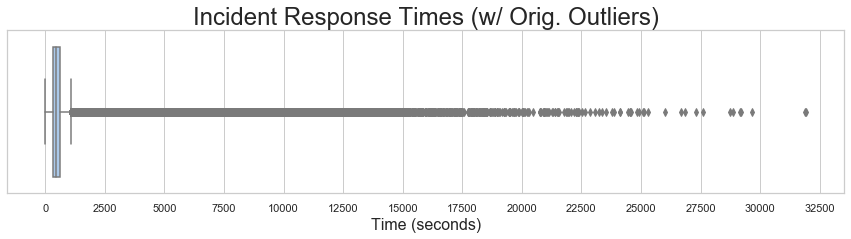

In [14]:
# Visualize spread of response times
fig3A1, ax3A1 = plt.subplots(figsize=(15,3))
ax3A1 = sb.boxplot(x='response_time',data=rspn_tm,orient='h')
ax3A1.set_title('Incident Response Times (w/ Orig. Outliers)',size=24)
ax3A1.set_xlabel('Time (seconds)',size=16)
ax3A1.set_xticks([2500*i for i in range(14)])
ax3A1.set_ylabel('',size=16)

#plt.savefig('../graphics/CP1-03_fig03A1.png') # Export plot to PNG file
plt.show()

In [15]:
# Calculate summary statistics
mean_rspn_tm = np.mean(rspn_tm.response_time)
quartiles = np.percentile(rspn_tm.response_time,[25,50,75])
median_rspn_tm = np.median(rspn_tm.response_time)
min_rspn_tm, max_rspn_tm = rspn_tm.response_time.min(),rspn_tm.response_time.max()

# Identify outliers
maxf_rspn_tm = quartiles[2]+1.5*(quartiles[2]-quartiles[0]) # "Maximum" (Q3 + 1.5*IQR)
outliers = rspn_tm.response_time[rspn_tm.response_time>maxf_rspn_tm]

# Output statistics
print('SUMMARY STATISTICS (Original)')
print(f'Total Number of Observations: {len(rspn_tm.response_time):8}')
print(f'Number of Outliers:           {len(outliers):8}')
print()
print(f'Mean:        {mean_rspn_tm:8.2f}')
print(f'Q1:          {quartiles[0]:8.2f}')
print(f'Median (Q2): {quartiles[1]:8.2f}')
print(f'Q3:          {quartiles[2]:8.2f}')
print()
print(f'Actual Minimum Response Time:          {min_rspn_tm:9.2f}')
print(f'\"Maximum\" Response Time (Q3 + 1.5*IQR):{maxf_rspn_tm:9.2f}')
print(f'Actual Maximum Response Time:          {max_rspn_tm:9.2f}')

SUMMARY STATISTICS (Original)
Total Number of Observations:  8054500
Number of Outliers:             577993

Mean:          556.46
Q1:            309.00
Median (Q2):   436.00
Q3:            624.00

Actual Minimum Response Time:               0.00
"Maximum" Response Time (Q3 + 1.5*IQR):  1096.50
Actual Maximum Response Time:           31931.00


The summary statistics above indicate there are a large number of outliers contained within this dataset. Therefore, the spread of `response_time` should be examined without these values to convolute the trends.

In [16]:
# Remove outlier observations from data
rspn_tm_adj = rspn_tm[rspn_tm.response_time<=maxf_rspn_tm]

# Calculate summary statistics
mean_rspn_tm_adj = np.mean(rspn_tm_adj.response_time)
quartiles_adj = np.percentile(rspn_tm_adj.response_time,[25,50,75])
median_rspn_tm_adj = np.median(rspn_tm_adj.response_time)
min_rspn_tm_adj, max_rspn_tm_adj = rspn_tm_adj.response_time.min(),rspn_tm_adj.response_time.max()

# Output statistics
print('SUMMARY STATISTICS (w/o Orig. Outliers)')
print(f'Total Number of Observations: {len(rspn_tm_adj.response_time):8}')
print()
print(f'Mean:        {mean_rspn_tm_adj:8.2f}')
print(f'Q1:          {quartiles_adj[0]:8.2f}')
print(f'Median (Q2): {quartiles_adj[1]:8.2f}')
print(f'Q3:          {quartiles_adj[2]:8.2f}')
print()
print(f'Actual Minimum Response Time: {min_rspn_tm_adj:9.2f}')
print(f'Actual Maximum Response Time: {max_rspn_tm_adj:9.2f}')

SUMMARY STATISTICS (w/o Orig. Outliers)
Total Number of Observations:  7476507

Mean:          450.05
Q1:            300.00
Median (Q2):   416.00
Q3:            570.00

Actual Minimum Response Time:      0.00
Actual Maximum Response Time:   1096.00


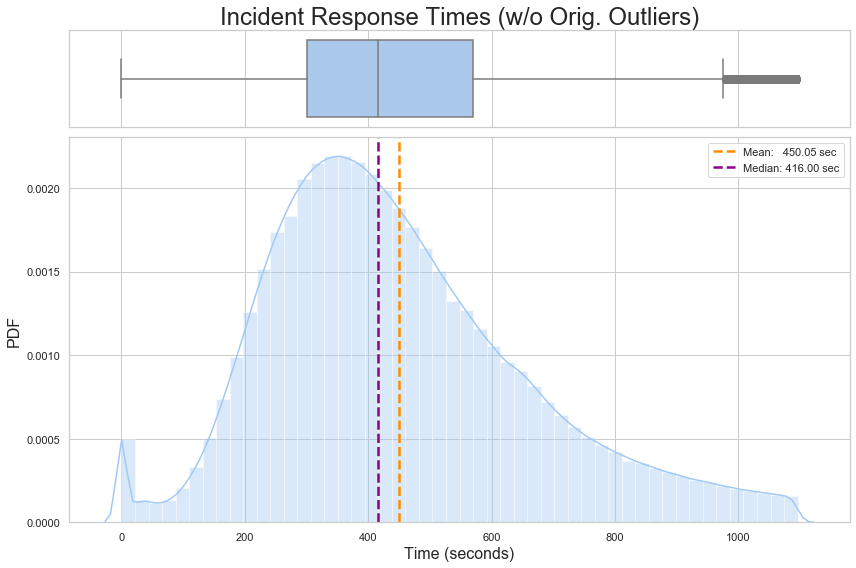

In [17]:
# Visualize boxplot and distribution of response times
fig3A2, ax3A2 = plt.subplots(2,figsize=(12,8),sharex=True, gridspec_kw={"height_ratios": (.20, .80)})
sb.boxplot(rspn_tm_adj.response_time, ax=ax3A2[0])
sb.distplot(rspn_tm_adj.response_time, ax=ax3A2[1])
ax3A2[0].set_title('Incident Response Times (w/o Orig. Outliers)',size=24)
ax3A2[0].set_xlabel('')
ax3A2[1].set_xlabel('Time (seconds)',size=16)
ax3A2[1].set_ylabel('PDF',size=16)

# Visualize mean and median response times
measurements = [mean_rspn_tm_adj,median_rspn_tm_adj]
names = ['Mean','Median']
colors = ['darkorange','darkmagenta']
for m, n, c in zip(measurements, names, colors):
    plt.axvline(x=m,linestyle='--',linewidth=2.5,label=f'{n+":":7} {m:.2f} sec',c=c)

plt.legend()
plt.tight_layout()
#plt.savefig('../graphics/CP1-03_fig03A2.png') # Export plot to PNG file
plt.show()

The distribution of incident response times is positively-skewed. All remaining observations will be parsed into two, independent samples based on the incident outcome: <strong>fatalities</strong> (`fatality == True`) and <strong>survivals</strong> (`fatality == False`). <p><a href=#TOC>TOC</a></p>

<a id="Sec03B"></a>
<h4>3B: Summary Statistics by Outcome Group</h4>

In [18]:
rspn_tm_F = rspn_tm_adj[rspn_tm_adj.fatality==True]  # fatalities

# Calculate summary statistics for fatalities
mean_rspn_tm_adj = np.mean(rspn_tm_F.response_time)
SE_rspn_tm_adj = stats.sem(rspn_tm_F.response_time)
quartiles_adj = np.percentile(rspn_tm_F.response_time,[25,50,75])
median_rspn_tm_adj = np.median(rspn_tm_F.response_time)
min_rspn_tm_adj, max_rspn_tm_adj = rspn_tm_F.response_time.min(),rspn_tm_F.response_time.max()

# Output statistics
print('SUMMARY STATISTICS: Fatalities (w/o Orig. Outliers)')
print(f'Total Number of Observations: {len(rspn_tm_F.response_time):8}')
print()
print(f'Mean:        {mean_rspn_tm_adj:8.2f}')
print(f'Std. Error:  {SE_rspn_tm_adj:8.2f}')
print()
print(f'Q1:          {quartiles_adj[0]:8.2f}')
print(f'Median (Q2): {quartiles_adj[1]:8.2f}')
print(f'Q3:          {quartiles_adj[2]:8.2f}')
print()
print(f'Actual Minimum Response Time: {min_rspn_tm_adj:8.2f}')
print(f'Actual Maximum Response Time: {max_rspn_tm_adj:8.2f}')

SUMMARY STATISTICS: Fatalities (w/o Orig. Outliers)
Total Number of Observations:   291954

Mean:          461.00
Std. Error:      0.41

Q1:            296.00
Median (Q2):   420.00
Q3:            592.00

Actual Minimum Response Time:     0.00
Actual Maximum Response Time:  1096.00


In [19]:
rspn_tm_S = rspn_tm_adj[rspn_tm_adj.fatality==False] # survivals

# Calculate summary statistics for survivals
mean_rspn_tm_adj = np.mean(rspn_tm_S.response_time)
SE_rspn_tm_adj = stats.sem(rspn_tm_S.response_time)
quartiles_adj = np.percentile(rspn_tm_S.response_time,[25,50,75])
median_rspn_tm_adj = np.median(rspn_tm_S.response_time)
min_rspn_tm_adj, max_rspn_tm_adj = rspn_tm_S.response_time.min(),rspn_tm_S.response_time.max()

# Output statistics
print('SUMMARY STATISTICS: Survivals (w/o Orig. Outliers)')
print(f'Total Number of Observations: {len(rspn_tm_S.response_time):8}')
print()
print(f'Mean:        {mean_rspn_tm_adj:8.2f}')
print(f'Std. Error:  {SE_rspn_tm_adj:8.2f}')
print()
print(f'Q1:          {quartiles_adj[0]:8.2f}')
print(f'Median (Q2): {quartiles_adj[1]:8.2f}')
print(f'Q3:          {quartiles_adj[2]:8.2f}')
print()
print(f'Actual Minimum Response Time: {min_rspn_tm_adj:8.2f}')
print(f'Actual Maximum Response Time: {max_rspn_tm_adj:8.2f}')

SUMMARY STATISTICS: Survivals (w/o Orig. Outliers)
Total Number of Observations:  7184553

Mean:          449.60
Std. Error:      0.08

Q1:            300.00
Median (Q2):   416.00
Q3:            569.00

Actual Minimum Response Time:     0.00
Actual Maximum Response Time:  1096.00


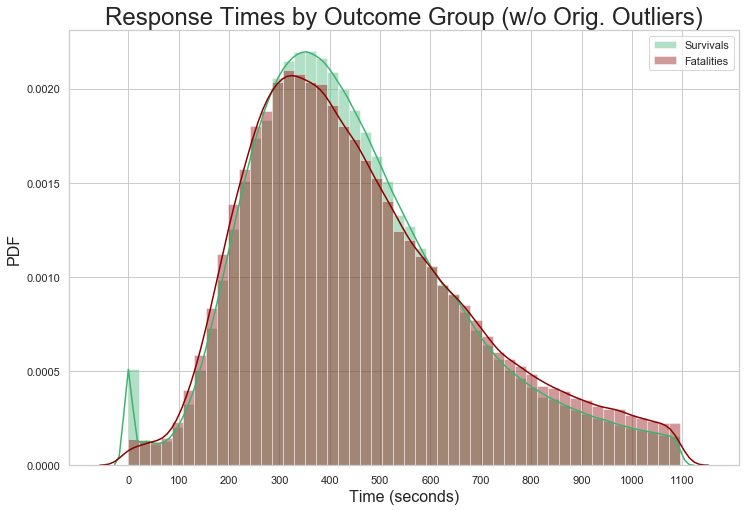

In [20]:
# Visualize distribution of response times for outcome groups on same axis
fig3B, ax3B = plt.subplots(figsize=(12,8))
ax3B = sb.distplot(rspn_tm_S.response_time,color='#3CB371',label='Survivals')
ax3B = sb.distplot(rspn_tm_F.response_time,color='#8b0000',label='Fatalities')
ax3B.set_title('Response Times by Outcome Group (w/o Orig. Outliers)',size=24)
ax3B.set_xlabel('Time (seconds)',size=16)
ax3B.set_xticks([100*i for i in range(12)])
ax3B.set_ylabel('PDF',size=16)

plt.legend()
#plt.savefig('../graphics/CP1-02_fig03B.png') # Export plot to PNG file
plt.show()

<p>The distributions of the two samples appear similar, but further analysis is required to determine whether or not there is any significant difference between the two groups. <a href=#TOC>TOC</a></p>

<a id="Sec03C"></a>
<h4>3C: Frequentist Test (Two-Sample)</h4>

<p>Is there a significant difference between the response times of incidents that result in fatalities and those where patients survive? Assuming a 95% confidence interval, the null hypothesis will only be rejected if the resulting test statistic is more than 1.96 standard deviations away from the mean.</p>
<ul>
    <li>$\mu_{rspn,F}$ = Mean response time for incidents resulting in fatality</li>
    <li>$\mu_{rspn,S}$ = Mean response time for incidents resulting in survival</li>
</ul>
<br>
<p>HYPOTHESIS TEST
<br>
$H_0$: $\mu_{rspn,F}$ = $\mu_{rspn,S}$ (the mean response times are the same)
<br>
$H_A$: $\mu_{rspn,F}$ $\neq$ $\mu_{rspn,S}$ (the mean response times are different)</p>

In [21]:
# Calculate means for samples
mu_F = np.mean(rspn_tm_F.response_time)
mu_S = np.mean(rspn_tm_S.response_time)

# Calculate standard error (se) for each sample
se_F = stats.sem(rspn_tm_F.response_time)
se_S = stats.sem(rspn_tm_S.response_time)

# Calculate the margin of error (me) for a 95% C.I. per sample
me_F = 1.96*se_F
me_S = 1.96*se_S

# Calculate the upper and lower bounds for each 95% C.I.
upper_F = mu_F + me_F
lower_F = mu_F - me_F
upper_S = mu_S + me_S
lower_S = mu_S - me_S

# Print results
print(f'Mean Response Time for Fatalities:    {mu_F:8.4f}')
print(f'Standard Error - Fatalities:          {se_F:8.4f}')
print(f'95% Confidence Interval - Fatalities: {lower_F:8.4f} to {upper_F:8.4f}')
print()
print(f'Mean Response Time for Survivals:     {mu_S:8.4f}')
print(f'Standard Error - Survivals:           {se_S:8.4f}')
print(f'95% Confidence Interval - Survivals:  {lower_S:8.4f} to {upper_S:8.4f}')

Mean Response Time for Fatalities:    460.9994
Standard Error - Fatalities:            0.4113
95% Confidence Interval - Fatalities: 460.1934 to 461.8055

Mean Response Time for Survivals:     449.6036
Standard Error - Survivals:             0.0788
95% Confidence Interval - Survivals:  449.4492 to 449.7579


In [22]:
# t-test
t_stat, t_pval = stats.ttest_ind(rspn_tm_F.response_time,
                                 rspn_tm_S.response_time,
                                 equal_var=False)
print(f't-statistic: {abs(t_stat):7.4f}')
print(f'p-value:     {t_pval:7.4f}')

t-statistic: 27.2156
p-value:      0.0000


In [23]:
# z-test
z_stat,z_pval = ztest(rspn_tm_F.response_time,
                      rspn_tm_S.response_time,
                      alternative='two-sided')
print(f'z-statistic: {abs(z_stat):7.4f}')
print(f'p-value:     {z_pval:7.4f}')

z-statistic: 28.5328
p-value:      0.0000


<p>The resulting <em>p</em>-value from the frequentists test above is well below the threshold of $\alpha = 0.05$. Thus, the null hypothesis must be rejected in favour of the alternative hypothesis at the 95% confidence interval. The mean response times for fatalities and survivals are statistically different. <a href=#TOC>TOC</a></p>